# Loading McDonalds Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

print('------ Data Head ------')
try:
    data = pd.read_csv('McDonald_s_Reviews.csv', encoding='latin1')
    print(data.head())
except Exception as e:
    print("Error reading file with latin1 encoding:", e)

print('\n')
print('------ Data Info ------')
print(data.info())
print('\n')
print('------ Descriptive Statistics ------')
print(data.describe())


------ Data Head ------
   reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   
2            3  McDonald's  Fast food restaurant   
3            4  McDonald's  Fast food restaurant   
4            5  McDonald's  Fast food restaurant   

                                       store_address  latitude   longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
2  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
3  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
4  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   
1        1,240    5 days ago   
2        1,240    5 days ago   
3        1,240   a month ago   
4        1,240  2 months ago   

 

#### Data Cleaning

In [3]:
# Trim spaces from column names
data.columns = data.columns.str.strip()

# Check the columns to ensure the names are correct
print("Corrected Columns in DataFrame:", data.columns)

# Proceed with filling missing values
data['latitude'].fillna(data['latitude'].median(), inplace=True)
data['longitude'].fillna(data['longitude'].median(), inplace=True)


Corrected Columns in DataFrame: Index(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')


/var/folders/4g/6t76_jvd3l76gv7sm7qxmbxr0000gq/T/ipykernel_26162/1611003812.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['latitude'].fillna(data['latitude'].median(), inplace=True)
/var/folders/4g/6t76_jvd3l76gv7sm7qxmbxr0000gq/T/ipykernel_26162/1611003812.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

In [4]:
# Ensure all entries in 'rating' are converted to integers
data['rating'] = data['rating'].apply(lambda x: int(x[0]) if isinstance(x, str) else x)

# Confirm the conversion
print("Data type of 'rating':", data['rating'].dtype)
print("First few entries in 'rating':", data['rating'].head())

Data type of 'rating': int64
First few entries in 'rating': 0    1
1    4
2    1
3    5
4    1
Name: rating, dtype: int64


## Sentiment Analysis

Sample compound scores:
0    0.5215
1    0.8687
2   -0.3535
3    0.0000
4   -0.8020
Name: compound, dtype: float64


Correlation between compound scores and ratings:
          compound    rating
compound  1.000000  0.671554
rating    0.671554  1.000000




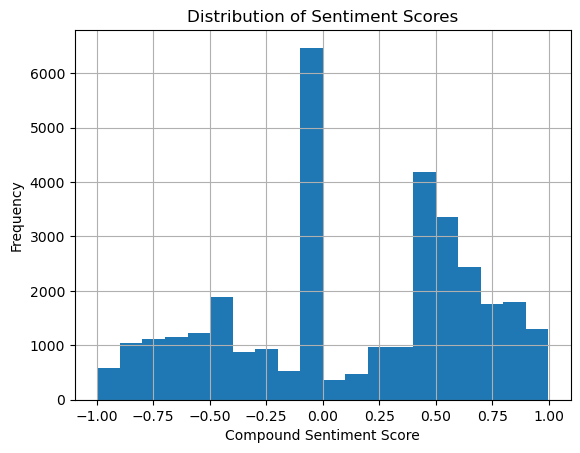

In [5]:
# Initialise the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the review column and extract the compound score
data['compound'] = data['review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Confirm that the 'compound' column has been added
print("Sample compound scores:")
print(data['compound'].head())
print('\n')
# Now let's retry the correlation and the histogram plot
print("Correlation between compound scores and ratings:")
print(data[['compound', 'rating']].corr())
print('\n')
# Visualization of sentiment distribution
data['compound'].hist(bins=20)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

## Aspect-based Sentiment Analysis

In [6]:
# Define aspects
aspects = {'service': ['staff', 'waiter', 'manager'],
           'food': ['burger', 'fries', 'meal', 'drink'],
           'cleanliness': ['clean', 'dirty', 'messy']}

# Function to search for aspects in text
def find_aspects(text):
    found_aspects = {key: any(word in text.lower() for word in words) for key, words in aspects.items()}
    return found_aspects

# Apply to the reviews
data['aspects'] = data['review'].apply(find_aspects)

# Display results
print(data['aspects'].head())


0    {'service': False, 'food': False, 'cleanliness...
1    {'service': True, 'food': False, 'cleanliness'...
2    {'service': True, 'food': False, 'cleanliness'...
3    {'service': False, 'food': False, 'cleanliness...
4    {'service': False, 'food': True, 'cleanliness'...
Name: aspects, dtype: object


In [7]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def aspect_sentences(text):
    sentences = sent_tokenize(text)
    aspect_dict = {key: [] for key in aspects}
    for sentence in sentences:
        for aspect, keywords in aspects.items():
            if any(keyword in sentence.lower() for keyword in keywords):
                aspect_dict[aspect].append(sentence)
    return aspect_dict

data['aspect_sentences'] = data['review'].apply(aspect_sentences)


[nltk_data] Downloading package punkt to /Users/kanishkaw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
def aspect_sentiment(aspect_dict):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = {aspect: [sia.polarity_scores(sentence)['compound'] for sentence in sentences]
                        for aspect, sentences in aspect_dict.items()}
    return sentiment_scores

data['aspect_sentiment'] = data['aspect_sentences'].apply(aspect_sentiment)


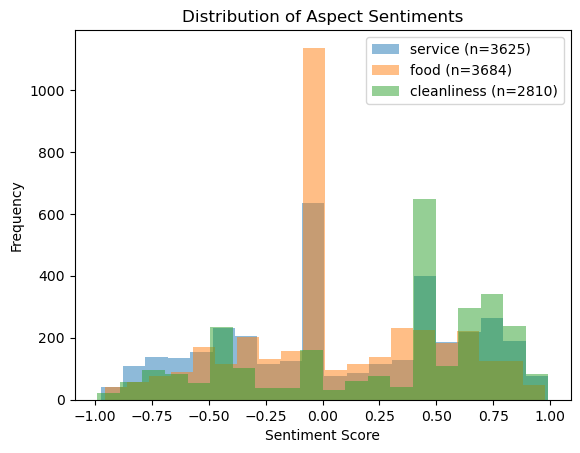

In [10]:
# Example: Calculate average sentiment for each aspect
def average_aspect_sentiment(sentiment_scores):
    return {aspect: np.mean(scores) if scores else None for aspect, scores in sentiment_scores.items()}

data['average_aspect_sentiment'] = data['aspect_sentiment'].apply(average_aspect_sentiment)


aspect_avgs = {aspect: [] for aspect in aspects}
for row in data['average_aspect_sentiment']:
    for aspect in aspects:
        if row[aspect] is not None:
            aspect_avgs[aspect].append(row[aspect])

fig, ax = plt.subplots()
for aspect, scores in aspect_avgs.items():
    ax.hist(scores, bins=20, alpha=0.5, label=f"{aspect} (n={len(scores)})")
ax.legend()
ax.set_title('Distribution of Aspect Sentiments')
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency')
plt.show()
